# Nonlinear Programming Visualization

In [1]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /Users/jerrywumacmini/Desktop/hopper_sim


## Visualize the Cost Function of Optimal Control

In [2]:
# ============================================================
# Initialize Hopper from YAML Configuration
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import yaml
from models.GRP_hopper import simplified_GRP_hopper
from mpl_toolkits.mplot3d import Axes3D

# Load YAML configuration
with open("./cfg/GRP_hopper.yaml", "r") as f:
    cfg = yaml.safe_load(f)["simplified_GRP_hopper"]

# Initialize hopper with physical parameters
mb = cfg["mb"]
mf = cfg["mf"]
k = cfg["k"]
c = cfg["c"]
l0 = cfg["l0"]
g = cfg["g"]

hopper = simplified_GRP_hopper(mb, mf, k, c, l0, g)

# Get NLP controller parameters
nlp_cfg = cfg["controller"]["NLP"]
x0 = np.array(cfg["x0"][0])

# Initialize NLP controller with Q_bh = 10 and R_u = 0
mode_seq_init = ["stance"] * nlp_cfg["H"]

controller = simplified_GRP_hopper.NLPController(
    hopper=hopper,
    H=nlp_cfg["H"],
    dt=nlp_cfg["dt_control"],
    x0=x0,
    mode_seq=mode_seq_init,
    Q_l=0.0,      # Leg length tracking - moderate weight
    R_u=0.0,     # Control effort penalty - small but non-zero
    u_min=nlp_cfg["u_min"],
    u_max=nlp_cfg["u_max"],
    l_ref=0.3,    # Target leg length
    Q_bh=10.0,    # Body height tracking - high priority
    Q_fh=0.0,     # Foot height tracking - low priority
    Q_bd=0.0,     # Body velocity damping - moderate weight
    body_ref=0.2,
    foot_ref=0.0
)

print("="*70)
print("Complex Cost Function Configuration")
print("="*70)
print(f"Q_l  = {controller.Q_l:.2f}  (leg length tracking)")
print(f"Q_bh = {controller.Q_bh:.2f} (body height tracking) ← HIGHEST")
print(f"Q_fh = {controller.Q_fh:.2f}  (foot height tracking)")
print(f"Q_bd = {controller.Q_bd:.2f}  (body velocity damping)")
print(f"R_u  = {controller.R_u:.3f} (control effort penalty)")
print("\nAll terms are now active!")
print("="*70)

Complex Cost Function Configuration
Q_l  = 0.00  (leg length tracking)
Q_bh = 10.00 (body height tracking) ← HIGHEST
Q_fh = 0.00  (foot height tracking)
Q_bd = 0.00  (body velocity damping)
R_u  = 0.000 (control effort penalty)

All terms are now active!



Closed-loop MPC for: Body Too Low

Step 1/5: Current state = xb=0.300m, vb=0.000m/s

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

  Applied control: u = -115.466 N
  Next state: xb=0.299m, vb=-0.337m/s

Step 2/5: Current state = xb=0.299m, vb=-0.337m/s
  Applied control: u = -74.840 N
  Next state: xb=0.297m, vb=-0.566m/s

Step 3/5: Current state = xb=0.297m, vb=-0.566m/s
  Applied control: u = -63.835 N
  Next state: xb=0.294m, vb=-0.759m/s

Step 4/5: Current state = xb=0.294m, vb=-0.759m/s
  Applied control: u = -56.135 N
  Next state: xb=0.289m, vb=-0.920m/s

Step 5/5: Current state = xb=0.289m, vb=-0.920m/s
  Applied control: u = -49.220 N
  Next

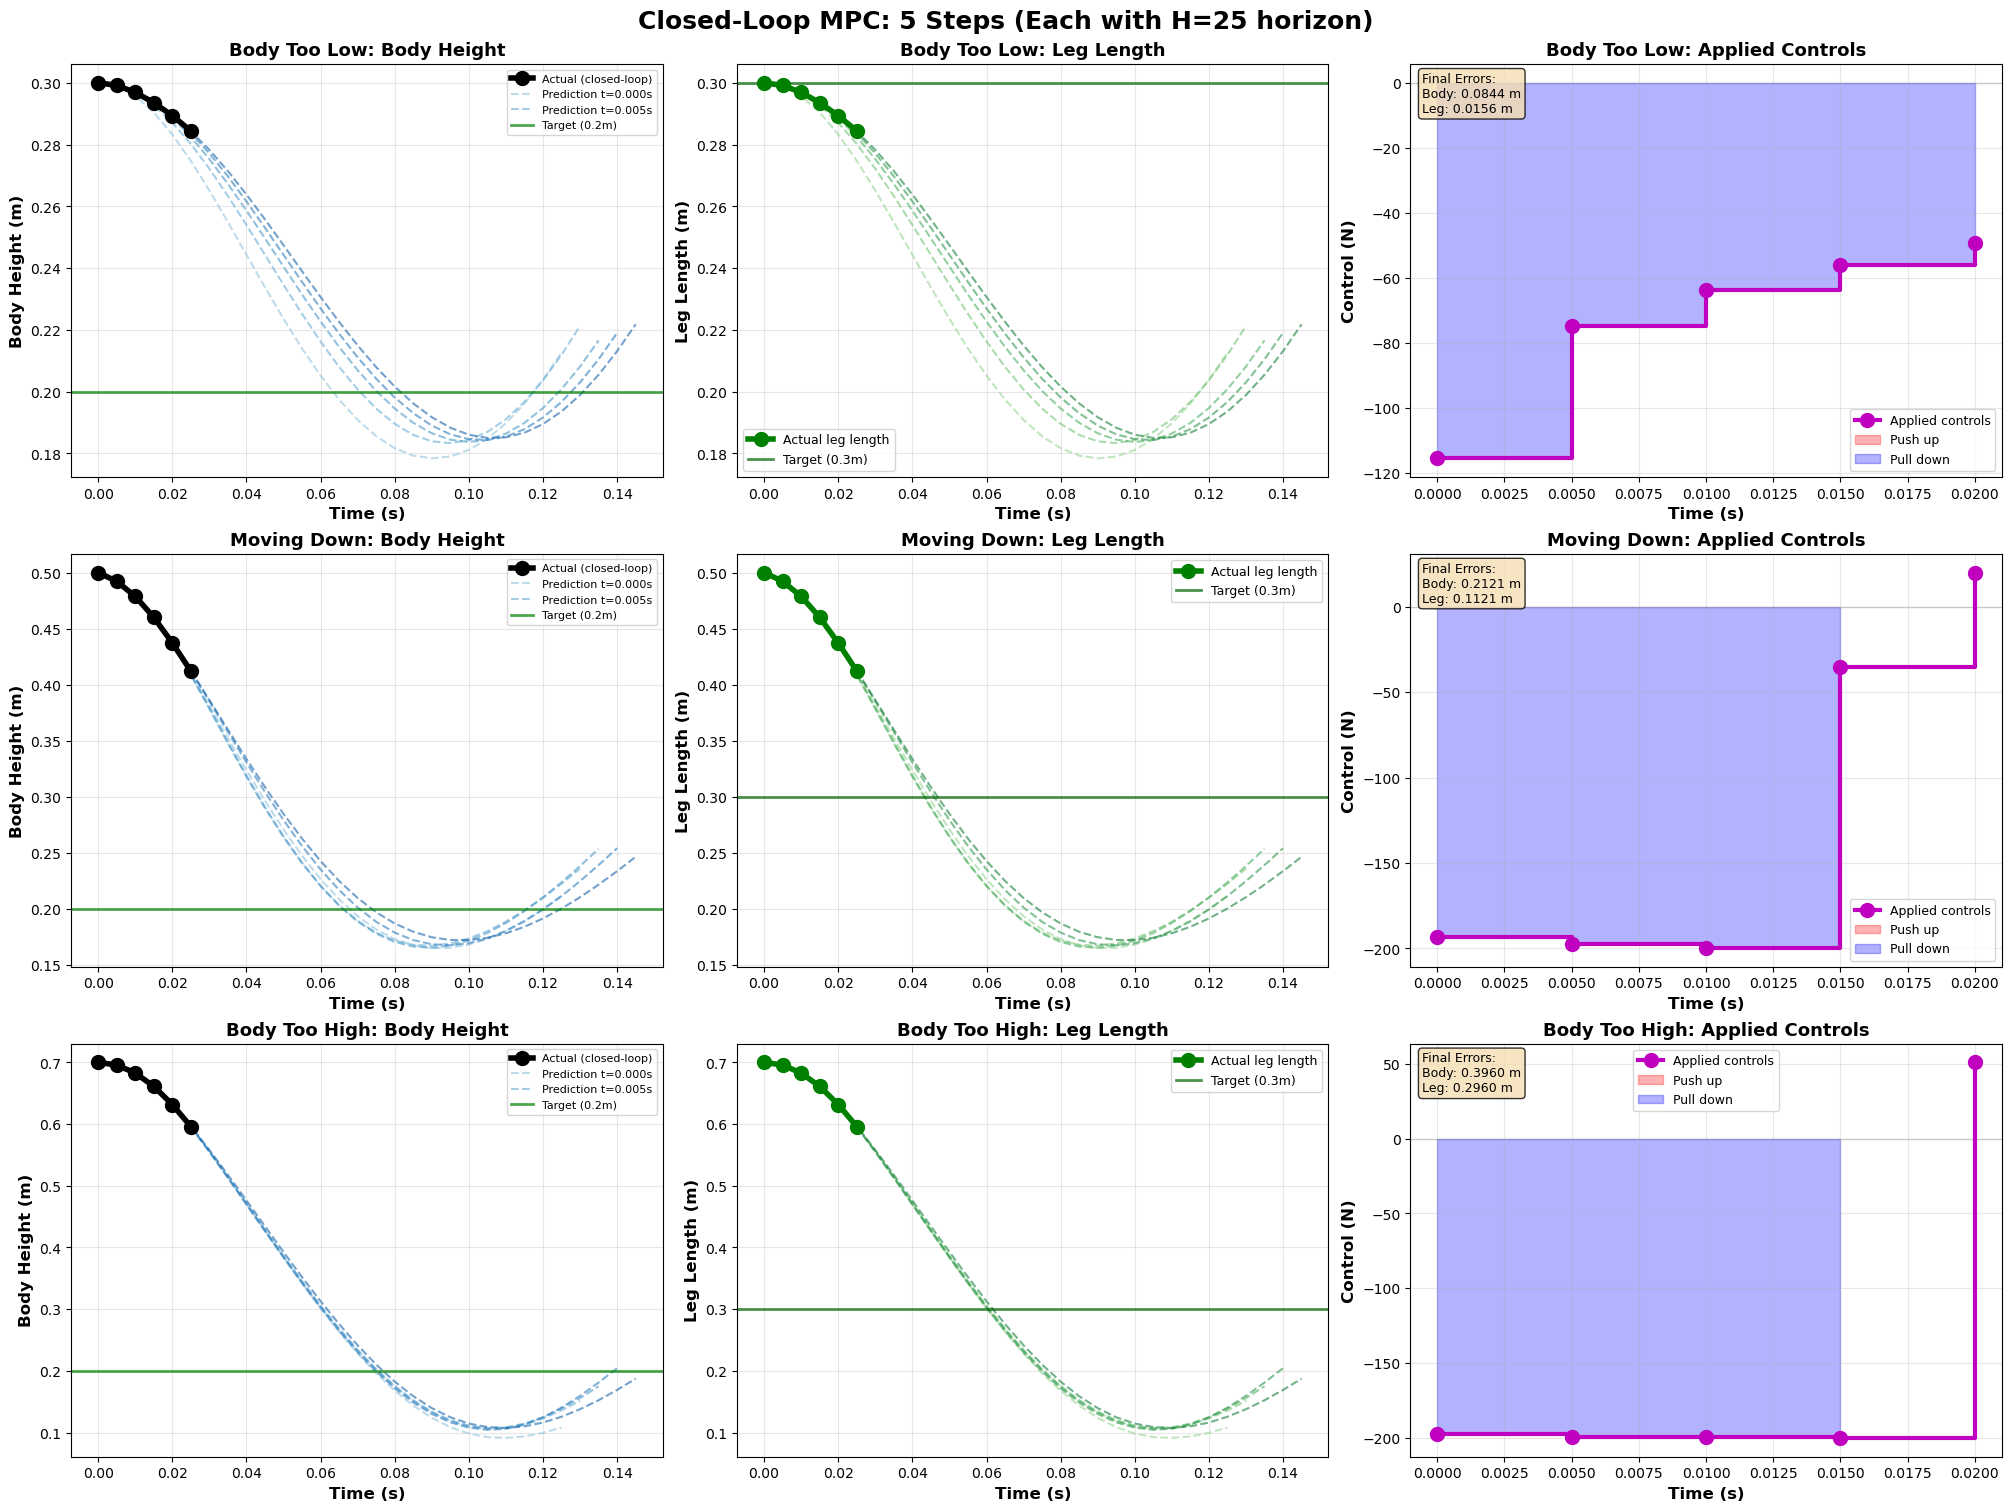


Closed-Loop MPC Analysis
• Number of MPC steps applied: 5
• Each MPC step predicts H = 25 steps ahead
• Total simulated time: 0.025 seconds
• Control frequency: 200 Hz

Key Observations:
• BLACK line = Actual closed-loop trajectory
• FADED lines = MPC predictions at each timestep (25-step horizons)
• MPC re-plans at each step (receding horizon)
• System should converge toward target if MPC is working correctly!


In [3]:
# ============================================================
# Closed-Loop MPC Simulation (5 Steps with 25-Step Horizons)
# ============================================================
# Apply MPC in closed loop to see if system approaches target

import cyipopt

def get_mpc_trajectory(controller, state):
    """
    Get the full MPC trajectory (not just u0).
    Returns X_opt (states) and U_opt (controls) over the horizon.
    """
    # Update initial state constraint
    controller.lb[:controller.nx] = state
    controller.ub[:controller.nx] = state
    
    # Warm start
    X0 = np.tile(state, controller.H + 1)
    U0 = np.zeros((controller.H + 1, controller.nu))
    w0 = np.concatenate([X0, U0.ravel()])
    
    # Build NLP instance
    nlp = cyipopt.Problem(
        n=controller.n,
        m=controller.m,
        problem_obj=controller,
        lb=controller.lb,
        ub=controller.ub,
        cl=controller.cl,
        cu=controller.cu,
    )
    
    # IPOPT settings (quiet)
    nlp.add_option("hessian_approximation", "limited-memory")
    nlp.add_option("limited_memory_max_history", 20)
    nlp.add_option("linear_solver", "mumps")
    nlp.add_option("tol", 1e-3)
    nlp.add_option("max_iter", 150)
    nlp.add_option("print_level", 0)
    
    # Solve NLP
    w_opt, info = nlp.solve(w0)
    
    # Unpack solution
    X_opt, U_opt = controller._unpack(w_opt)
    
    return X_opt, U_opt

def simulate_one_step(hopper, state, u, dt, mode='stance'):
    """Simulate system forward by one timestep using trapezoidal integration."""
    if mode == 'stance':
        f_k, _ = hopper.stance_state(state, u)
        state_next = state + dt * f_k
        f_kp1, _ = hopper.stance_state(state_next, u)
    else:
        f_k, _ = hopper.flight_state(state, u)
        state_next = state + dt * f_k
        f_kp1, _ = hopper.flight_state(state_next, u)
    
    # Trapezoidal integration
    state_next = state + 0.5 * dt * (f_k + f_kp1)
    return state_next

# Number of MPC steps to apply in closed loop
N_mpc_steps = 5

# Test cases for closed-loop simulation
test_cases_cl = [
    ('Body Too Low', np.array([0.3, 0.0, 0.0, 0.0])),
    ('Moving Down', np.array([0.5, -1.0, 0.0, 0.0])),
    ('Body Too High', np.array([0.7, 0.0, 0.0, 0.0])),
]

fig, axes = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)
fig.suptitle(f'Closed-Loop MPC: {N_mpc_steps} Steps (Each with H={controller.H} horizon)', 
             fontsize=18, fontweight='bold')

for idx, (case_name, initial_state) in enumerate(test_cases_cl):
    print(f"\n{'='*70}")
    print(f"Closed-loop MPC for: {case_name}")
    print(f"{'='*70}")
    
    # Storage for closed-loop trajectory
    actual_states = [initial_state.copy()]
    applied_controls = []
    all_predictions = []  # Store all MPC predictions at each step
    
    current_state = initial_state.copy()
    
    # Run MPC in closed loop
    for step in range(N_mpc_steps):
        print(f"\nStep {step+1}/{N_mpc_steps}: Current state = "
              f"xb={current_state[0]:.3f}m, vb={current_state[1]:.3f}m/s")
        
        # Solve MPC from current state
        X_pred, U_pred = get_mpc_trajectory(controller, current_state)
        all_predictions.append((X_pred.copy(), U_pred.copy()))
        
        # Apply first control
        u_apply = U_pred[0, 0]
        applied_controls.append(u_apply)
        print(f"  Applied control: u = {u_apply:.3f} N")
        
        # Simulate system forward one step
        current_state = simulate_one_step(hopper, current_state, u_apply, 
                                         controller.dt, mode='stance')
        actual_states.append(current_state.copy())
        print(f"  Next state: xb={current_state[0]:.3f}m, vb={current_state[1]:.3f}m/s")
    
    # Convert to arrays
    actual_states = np.array(actual_states)
    applied_controls = np.array(applied_controls)
    actual_time = np.arange(len(actual_states)) * controller.dt
    
    # Row for this test case
    ax_row = axes[idx]
    
    # ===== Plot 1: Body Height - Actual vs Predictions =====
    ax = ax_row[0]
    
    # Plot actual closed-loop trajectory (thick line)
    ax.plot(actual_time, actual_states[:, 0], 'ko-', linewidth=4, markersize=10,
            label='Actual (closed-loop)', zorder=10)
    
    # Plot MPC predictions at each step (thin faded lines)
    colors_pred = plt.cm.Blues(np.linspace(0.4, 0.8, N_mpc_steps))
    for step_idx, (X_pred, U_pred) in enumerate(all_predictions):
        pred_time = actual_time[step_idx] + np.arange(len(X_pred)) * controller.dt
        ax.plot(pred_time, X_pred[:, 0], '--', color=colors_pred[step_idx], 
                linewidth=1.5, alpha=0.6, 
                label=f'Prediction t={actual_time[step_idx]:.3f}s' if step_idx < 2 else None)
    
    # Target line
    ax.axhline(controller.body_ref, color='green', linestyle='-', linewidth=2, 
               alpha=0.7, label=f'Target ({controller.body_ref}m)')
    
    ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Body Height (m)', fontsize=12, fontweight='bold')
    ax.set_title(f'{case_name}: Body Height', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')
    
    # ===== Plot 2: Leg Length - Actual vs Target =====
    ax = ax_row[1]
    
    actual_leg_length = actual_states[:, 0] - actual_states[:, 2]
    ax.plot(actual_time, actual_leg_length, 'go-', linewidth=4, markersize=10,
            label='Actual leg length', zorder=10)
    
    # Plot MPC predictions
    colors_pred_leg = plt.cm.Greens(np.linspace(0.4, 0.8, N_mpc_steps))
    for step_idx, (X_pred, U_pred) in enumerate(all_predictions):
        pred_time = actual_time[step_idx] + np.arange(len(X_pred)) * controller.dt
        pred_leg = X_pred[:, 0] - X_pred[:, 2]
        ax.plot(pred_time, pred_leg, '--', color=colors_pred_leg[step_idx], 
                linewidth=1.5, alpha=0.6)
    
    ax.axhline(controller.l_ref, color='darkgreen', linestyle='-', linewidth=2, 
               alpha=0.7, label=f'Target ({controller.l_ref}m)')
    
    ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Leg Length (m)', fontsize=12, fontweight='bold')
    ax.set_title(f'{case_name}: Leg Length', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    
    # ===== Plot 3: Applied Controls =====
    ax = ax_row[2]
    
    control_time = actual_time[:-1]  # Controls applied before state transitions
    ax.step(control_time, applied_controls, 'mo-', linewidth=3, markersize=10,
            where='post', label='Applied controls', zorder=10)
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
    
    # Shade regions
    ax.fill_between(control_time, 0, applied_controls, where=applied_controls>0,
                    alpha=0.3, color='red', step='post', label='Push up')
    ax.fill_between(control_time, 0, applied_controls, where=applied_controls<0,
                    alpha=0.3, color='blue', step='post', label='Pull down')
    
    ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Control (N)', fontsize=12, fontweight='bold')
    ax.set_title(f'{case_name}: Applied Controls', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    
    # Add performance metrics
    final_body_error = abs(actual_states[-1, 0] - controller.body_ref)
    final_leg_error = abs((actual_states[-1, 0] - actual_states[-1, 2]) - controller.l_ref)
    
    info_text = f'Final Errors:\n'
    info_text += f'Body: {final_body_error:.4f} m\n'
    info_text += f'Leg: {final_leg_error:.4f} m'
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.show()

print("\n" + "="*80)
print("Closed-Loop MPC Analysis")
print("="*80)
print(f"• Number of MPC steps applied: {N_mpc_steps}")
print(f"• Each MPC step predicts H = {controller.H} steps ahead")
print(f"• Total simulated time: {N_mpc_steps * controller.dt:.3f} seconds")
print(f"• Control frequency: {1/controller.dt:.0f} Hz")
print("\nKey Observations:")
print("• BLACK line = Actual closed-loop trajectory")
print("• FADED lines = MPC predictions at each timestep (25-step horizons)")
print("• MPC re-plans at each step (receding horizon)")
print("• System should converge toward target if MPC is working correctly!")
print("="*80)


Creating cost function landscape visualization...
Solving MPC to find optimal solution...
Computing cost function over state space...
  Progress: 30/150 rows
  Progress: 60/150 rows
  Progress: 90/150 rows
  Progress: 120/150 rows
  Progress: 150/150 rows
Done!


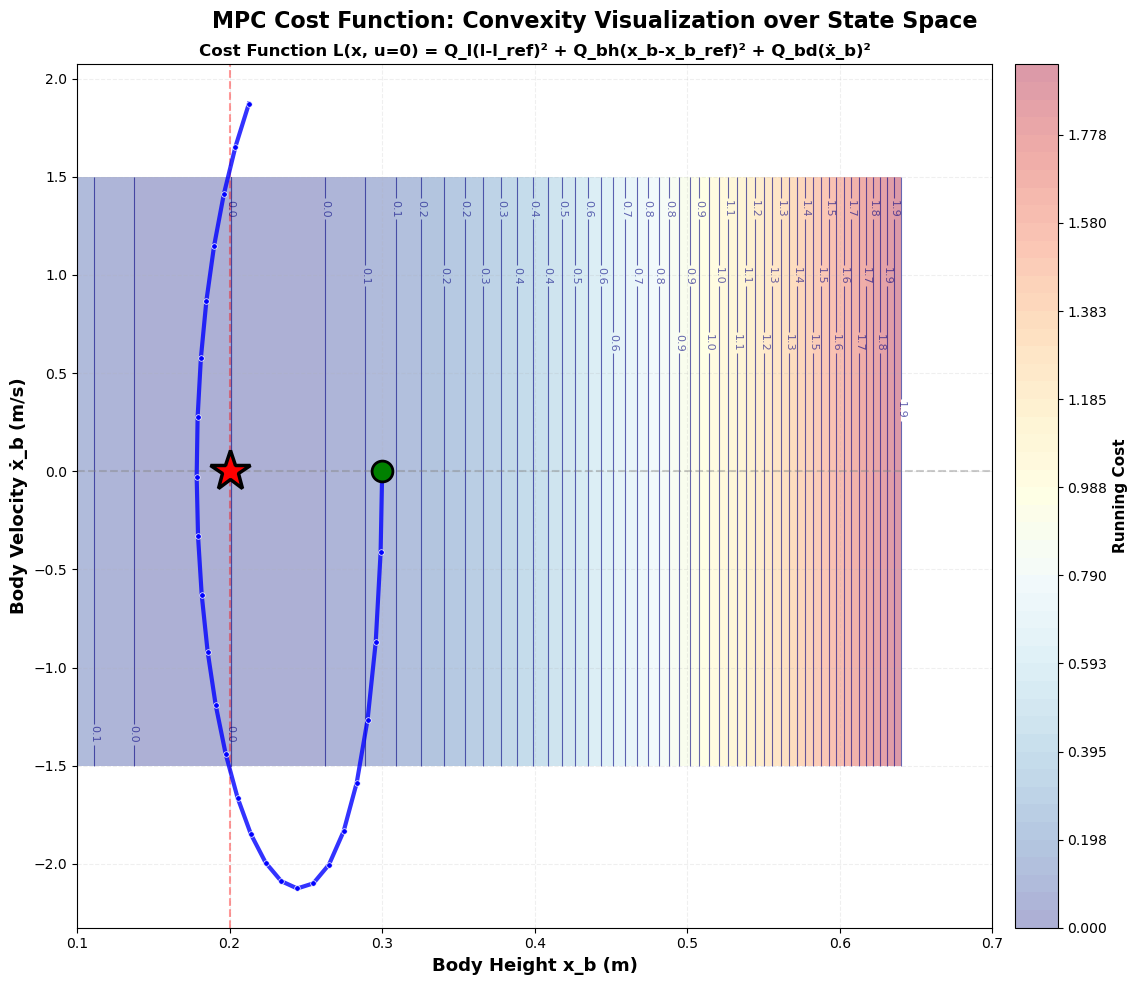

\n================================================================================
Cost Function Convexity Analysis
Minimum cost: 0.0000
Located at: (x_b=0.20m, ẋ_b=0.0 m/s)
\nCost Function Form:
  L(x,u) = Q_l*(l-l_ref)² + Q_bh*(x_b-x_b_ref)² + Q_bd*ẋ_b² + R_u*u²
\nWeights:
  Q_bh = 10.00 → Body height tracking
  Q_l  = 0.00 → Leg length tracking
  Q_bd = 0.00 → Velocity damping
  R_u  = 0.0000 → Control effort penalty
\nConvexity Properties:
  ✓ Quadratic form → Convex
  ✓ Positive definite weighting → Convex
  ✓ Elliptical level sets (shown in contours)
  ✓ Single global minimum at reference state
  ✓ MPC can reliably find optimal solution!


In [11]:
# ============================================================
# Cost Function Landscape (Convexity Visualization)
# ============================================================
# Visualize the MPC cost function over state space to show convexity

# We'll plot the running cost function over (x_b, x_b_dot) state space
# Similar to Rosenbrock visualization but for our MPC cost

print("Creating cost function landscape visualization...")

# Solve MPC to get the optimal solution
test_state = np.array([0.3, 0.0, 0.0, 0.0])
print("Solving MPC to find optimal solution...")
X_opt_ref, U_opt_ref = get_mpc_trajectory(controller, test_state)

# Create grid over state space (body height x_b and body velocity x_b_dot)
x_b_range = np.linspace(0.1, 0.7, 150)
x_b_dot_range = np.linspace(-1.5, 1.5, 150)
X_B_grid, X_B_DOT_grid = np.meshgrid(x_b_range, x_b_dot_range)
Cost_grid = np.zeros_like(X_B_grid)

print("Computing cost function over state space...")

# For each point in state space, evaluate the running cost
# We use u=0 to isolate the state cost (or use optimal u for that state)
for i in range(X_B_grid.shape[0]):
    for j in range(X_B_grid.shape[1]):
        x_b_val = X_B_grid[i, j]
        x_b_dot_val = X_B_DOT_grid[i, j]
        
        # Create state vector (x_b, x_b_dot, x_f=0, x_f_dot=0)
        state = np.array([x_b_val, x_b_dot_val, 0.0, 0.0])
        
        # Evaluate running cost at this state with u=0 (state cost only)
        cost = controller._running_cost(state, 0.0)
        
        Cost_grid[i, j] = cost
    
    if (i+1) % 30 == 0:
        print(f"  Progress: {i+1}/{X_B_grid.shape[0]} rows")

print("Done!")

# Create the visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
fig.suptitle('MPC Cost Function: Convexity Visualization over State Space', 
             fontsize=16, fontweight='bold')

# Plot contour lines
levels = np.linspace(Cost_grid.min(), np.percentile(Cost_grid, 90), 50)
contour = ax.contour(X_B_grid, X_B_DOT_grid, Cost_grid, levels=levels, 
                     colors='navy', linewidths=0.8, alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8, fmt='%.1f')

# Plot filled contours for better visualization
contourf = ax.contourf(X_B_grid, X_B_DOT_grid, Cost_grid, levels=levels, 
                       cmap='RdYlBu_r', alpha=0.4)

# Add colorbar
cbar = plt.colorbar(contourf, ax=ax, pad=0.02)
cbar.set_label('Running Cost', fontsize=11, fontweight='bold')

# Plot the reference (optimal) state
ax.plot(controller.body_ref, 0.0, 'r*', markersize=30, 
        markeredgecolor='black', markeredgewidth=2.5, 
        label=f'Optimal State (x_b={controller.body_ref}m, ẋ_b=0)', zorder=10)

# Plot the initial state from MPC solution
ax.plot(test_state[0], test_state[1], 'go', markersize=15, 
        markeredgecolor='black', markeredgewidth=2, 
        label=f'Initial State (x_b={test_state[0]}m)', zorder=9)

# Plot MPC trajectory on cost landscape
ax.plot(X_opt_ref[:, 0], X_opt_ref[:, 1], 'b-', linewidth=3, alpha=0.8,
        label='MPC Trajectory (predicted)', zorder=8)
ax.plot(X_opt_ref[:, 0], X_opt_ref[:, 1], 'bo', markersize=4, 
        markeredgecolor='white', markeredgewidth=0.5, zorder=8)

# Add constraint/reference lines
ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.4, label='Zero velocity')
ax.axvline(controller.body_ref, color='red', linestyle='--', linewidth=1.5, 
           alpha=0.4, label=f'Target x_b={controller.body_ref}m')

# Formatting
ax.set_xlabel('Body Height x_b (m)', fontsize=13, fontweight='bold')
ax.set_ylabel('Body Velocity ẋ_b (m/s)', fontsize=13, fontweight='bold')
ax.set_title('Cost Function L(x, u=0) = Q_l(l-l_ref)² + Q_bh(x_b-x_b_ref)² + Q_bd(ẋ_b)²', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.2, linestyle='--')
# ax.legend(fontsize=7, loc='upper left')

# Add annotation for optimal point
# ax.annotate('Global Minimum\\n(Convex!)',
#             xy=(controller.body_ref, 0.0), xytext=(30, 40),
#             textcoords='offset points',
#             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
#                           lw=2.5, color='red'),
#             fontsize=12, fontweight='bold')

# Add cost function info
# cost_text = f'Cost Function Components:\\n'
# cost_text += f'Q_bh = {controller.Q_bh:.1f} (body height)\\n'
# cost_text += f'Q_l = {controller.Q_l:.1f} (leg length)\\n'
# cost_text += f'Q_bd = {controller.Q_bd:.1f} (velocity damping)\\n'
# cost_text += f'R_u = {controller.R_u:.3f} (control effort)'
# ax.text(0.02, 0.98, cost_text, transform=ax.transAxes,
#         fontsize=10, verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add convexity note
# convex_text = 'Convex Function:\\nElliptical level sets\\nUnique global minimum\\nNo local minima'
# ax.text(0.98, 0.02, convex_text, transform=ax.transAxes,
#         fontsize=10, verticalalignment='bottom', horizontalalignment='right',
#         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
#         fontweight='bold')

plt.tight_layout()
plt.show()

print("\\n" + "="*80)
print("Cost Function Convexity Analysis")
print("="*80)
print(f"Minimum cost: {Cost_grid.min():.4f}")
print(f"Located at: (x_b={controller.body_ref:.2f}m, ẋ_b=0.0 m/s)")
print(f"\\nCost Function Form:")
print(f"  L(x,u) = Q_l*(l-l_ref)² + Q_bh*(x_b-x_b_ref)² + Q_bd*ẋ_b² + R_u*u²")
print(f"\\nWeights:")
print(f"  Q_bh = {controller.Q_bh:.2f} → Body height tracking")
print(f"  Q_l  = {controller.Q_l:.2f} → Leg length tracking")
print(f"  Q_bd = {controller.Q_bd:.2f} → Velocity damping")
print(f"  R_u  = {controller.R_u:.4f} → Control effort penalty")
print(f"\\nConvexity Properties:")
print(f"  ✓ Quadratic form → Convex")
print(f"  ✓ Positive definite weighting → Convex")
print(f"  ✓ Elliptical level sets (shown in contours)")
print(f"  ✓ Single global minimum at reference state")
print(f"  ✓ MPC can reliably find optimal solution!")
print("="*80)
